# Прогноз стоимости подержанных автомобилей

## Содержание

**[1. Обзор данных](#1)**

- **[1.1 Ввод необходимых функций](#1.1)**
- **[1.2 Разведочный анализ данных](#1.2)**
- **[1.3 Общие выводы по качеству имеющихся данных](#1.3)**


**[2. Подготовка данных](#2)**

- **[2.1. Предобработка данных](#2.1)**
- **[2.2. Проверка данных на мультиколлинеарность](#2.2)**
- **[2.3. Общие выводы по подготовке данных ](#2.3)**


**[3. Обучение моделей](#3)**

- **[3.1. Пробразование категорий в число](#3.1)**
- **[3.2. Проверка метода word_str. Объединение значений символов](#3.2)**
- **[3.3. Проверка метода word_int. Сумма значений символов](#3.3)**
- **[3.4. Модель линейной регрессии](#3.4)**
- **[3.5. Модель Решающего дерева](#3.5)**
- **[3.6. Методы улучшения качества моделей](#3.6)**
- **[3.7. Общие выводы](#3.7)**


**[4. Подготовка контрольного датасета](#4)**

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

Предлагаем вам принять участие в Мастерской, в рамках которой вы сможете поработать с данными о продажах автомобилей на вторичном рынке. Целью вашего проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

Основной критерий победы в соревновании - точность предсказания.

**Соревнование на платформе Kaggle.** Стоимость поддержанного автомобиля. Предскажи стоимость автомобиля на вторичном рынке.

**Цель Соревнования.** Разработка модели, которая достигнет наилучшего значения показателя `MAPE` (Mean Absolute Percentage Error).

**Цель исследования.** Построить модель для определения стоимости автомобиля с высоким качеством предсказания.

**Задачи:**
- загрузить и ознакомится с данными,
- провести предварительную обработку,
- сделать полноценный разведочный анализ,
- разработать новые синтетические признаки,
- проверить на мультиколлинеарность,
- сделать отбор финального набора обучающих признаков,
- выбрать и обучить модели,
- провести итоговую оценку качества предсказания лучшей модели,
- сделать анализ важности признаков модели.

**Входные данные.** Три файла в формате `.csv` с данными о продаваемых машинах:
1. `train.csv` - информация о характеристиках автомобилей (~440000), которые будут использоваться в качестве обучающих данных.
2. `test.csv` - информация о характеристиках автомобилей (~110000), которые будут использоваться в качестве тестовых данных.
3. `sample_submission.csv` - пример файла предсказаний в правильном формате.

**Формальная задача.** Предсказать значение `'sellingprice'` для каждого автомобиля из датасета `test.csv`.

**Ожидаемый результат.** Построена модель для определения стоимости автомобиля, со значением метрики `MAPE` не более **15**.


## Обзор данных <a id='1'></a>

**Признаки**

- `year` – год выпуска автомобиля.
- `make` – марка автомобиля.
- `model` – модель автомобиля определенной марки.
- `trim` – уровень отделки салона автомобиля.
- `body` – тип кузова транспортного средства.
- `transmission` – тип коробки передач.
- `vin` – идентификационный номер транспортного средства.
- `state` – состояние, в котором автомобиль выставлен на аукцион.
- `condition` – оценка состояние автомобилей на момент аукциона.
- `odometer` – расстояние, пройденное автомобилем с момента выпуска.
- `color` – цвет кузова автомобиля.
- `interior` – цвет салона автомобиля.
- `seller` – продавец автомобиля, автосалоны.
- `saledate` – дата продажи автомобиля. 

**Целевой признак**

- `sellingprice` – цена, по которой автомобиль был продан на аукционе.

In [1]:
# Импорт библиотек
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from time import time

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_percentage_error

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

In [2]:
# Введем константу
state = RandomState(12345)

### Ввод необходимых функций <a id='1.1'></a>

In [3]:
# Функция исследования датасета
def info_df(df_name):
    st = df_name.shape[0]
    col = df_name.shape[1]
    zerro = df_name.isna().sum()
    vin = len(df_name['vin'].unique())
    print(f'Размер таблиы: {col} столбцов и {st} строк')
    print(f'Общее количество пропусков - {zerro.sum()}')
    print(df_name.isna().sum())
    print()
    print(f'Количество явных дубликатов: {df_name.duplicated().sum()}')
    print(f'Количество уникальных VIN: {vin}')
    print()
    print(df_name.info())
    print()
    display(df_name.describe().round(2))

In [4]:
# Функция построения типовых гистограмм
def hist_pattern(df, title):
    df.hist(bins=50, figsize=(6,4))
    plt.title(title)
    return plt.show()


In [5]:
# Функция преобразования слова в число
def word_int(word):
    list_word = list(word) # Преобразуем слово в список
    list_int = [] 
    
    # Преобразуем каждую букву списка в число
    for i in range(len(list_word)):
        list_int.append((i+1)*ord(list_word[i]))
    
    return sum(list_int) # вернем сумму чисел

In [6]:
# Функция преобразования слова в строку чисел
def word_str(word):
    list_word = list(word) # Преобразуем слово в список
    list_str = [] 
    
    # Преобразуем каждую букву списка в число строкового типа 
    for i in range(len(list_word)):
        list_str.append(str((i+1)*ord(list_word[i])))
    
    return int(''.join(list_str)) # вернем строку чисел

In [7]:
# Функция преобразования месяца в время года
# 1 - Зима
# 2 - Весна
# 3 - Лето
# 4 - Осень

def season(month):
    if month == 1 or month == 2 or month == 12:
        return 1
    elif month == 3 or month == 4 or month == 5:
        return 2
    elif month == 6 or month == 7 or month == 8:
        return 3
    elif month == 9 or month == 10 or month == 11:
        return 4
        

### Разведочный анализ данных <a id='1.2'></a>

In [8]:
# Чтение файлов
path = 'C:\\Users\\User\\first_notebook\\Praktikum\\auto_prixe_predict\\'

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
df_sample = pd.read_csv(path + 'sample_submission.csv')


In [9]:
df_train.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)


In [10]:
df_train['vin_transmis'] = df_train['vin'].apply(lambda x: x[6])

In [11]:
# Обследуем данные
info_df(df_train)

Размер таблиы: 16 столбцов и 440236 строк
Общее количество пропусков - 97003
year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
vin_transmis        0
dtype: int64

Количество явных дубликатов: 0
Количество уникальных VIN: 440236

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 no

,year,condition,odometer,sellingprice
count,440236.00,430831.00,440167.00,440236.00
mean,2010.04,3.43,68344.42,13592.21
std,3.98,0.95,53542.20,9751.48
min,1982.00,1.00,1.00,1.00
25%,2007.00,2.70,28258.00,6900.00
50%,2012.00,3.60,52098.00,12100.00
75%,2013.00,4.20,99272.00,18200.00
max,2015.00,5.00,999999.00,230000.00


**Расмотрим данные по году выпуска**

In [12]:
# Исследуем год выпуска
df_train['year'].unique()

array([2011, 2014, 2012, 2003, 2007, 2013, 2010, 2000, 2005, 2006, 2004,
       2008, 2009, 2015, 2002, 2001, 1999, 1998, 1996, 1997, 1994, 1995,
       1993, 1989, 1991, 1988, 1987, 1990, 1992, 1985, 1986, 1983, 1984,
       1982], dtype=int64)

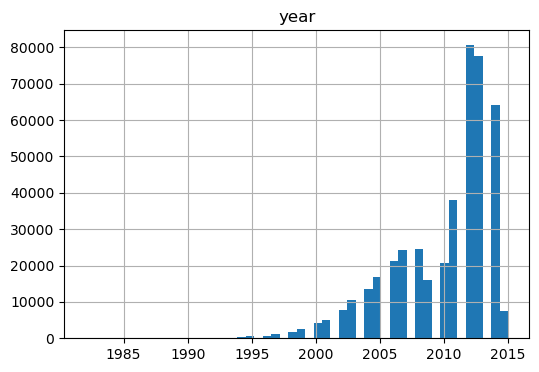

In [13]:
hist_pattern(df_train['year'], 'year')

<Axes: xlabel='sellingprice', ylabel='year'>

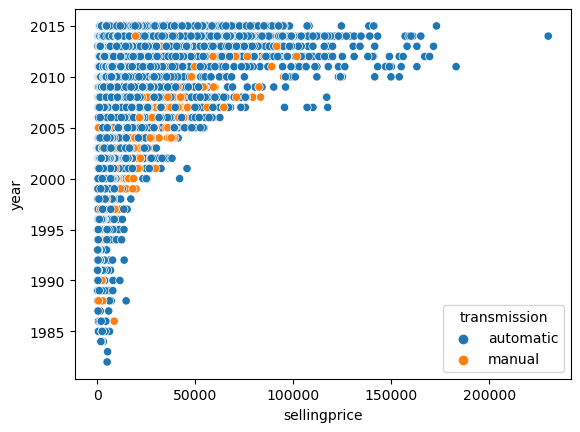

In [14]:
sns.scatterplot(
    data=df_train, 
    x="sellingprice", 
    y="year", 
    hue="transmission", 
)

**Расмотрим данные по состоянию автомобиля**

In [15]:
# Исследуем состояние автомобиля
df_train['condition'].unique()

array([4.2, 3.5, 2.2, 2.8, 2. , 2.5, 3.4, 4.8, 1.9, 1. , 3.1, 2.7, 3.6,
       2.9, 4.1, 2.6, 2.1, 3. , 4.9, 4.7, 4. , 3.3, 3.8, 3.7, 4.5, 4.6,
       5. , 4.3, 2.4, 2.3, 3.9, nan, 3.2, 4.4, 1.4, 1.5, 1.7, 1.2, 1.3,
       1.6, 1.8, 1.1])

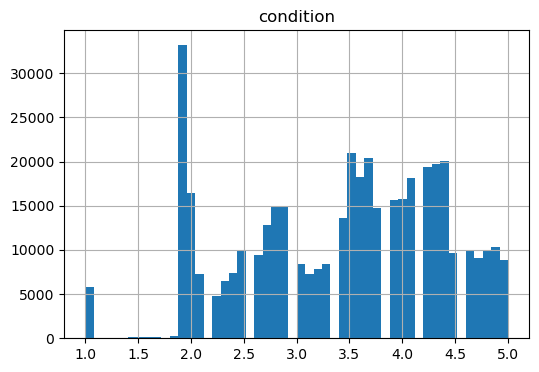

In [16]:
hist_pattern(df_train['condition'], 'condition')

<Axes: xlabel='sellingprice', ylabel='condition'>

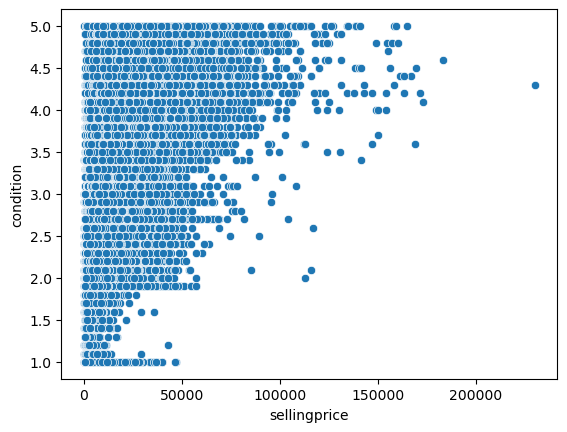

In [17]:
sns.scatterplot(
    data=df_train, 
    x="sellingprice", 
    y="condition", 
)

**Расмотрим данные по пробегу автомобиля**

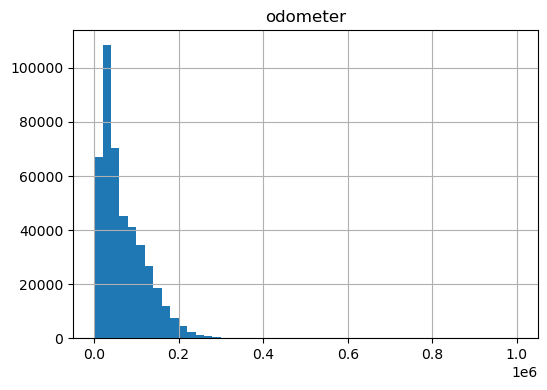

In [18]:
hist_pattern(df_train['odometer'], 'odometer')

<Axes: xlabel='sellingprice', ylabel='odometer'>

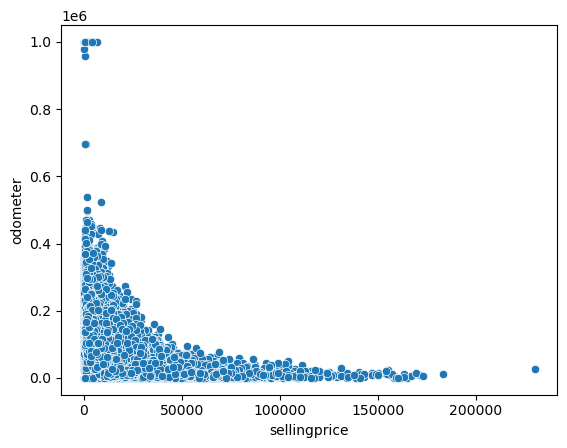

In [19]:
sns.scatterplot(
    data=df_train, 
    x="sellingprice", 
    y="odometer" 
)

**Расмотрим данные по цене автомобиля**

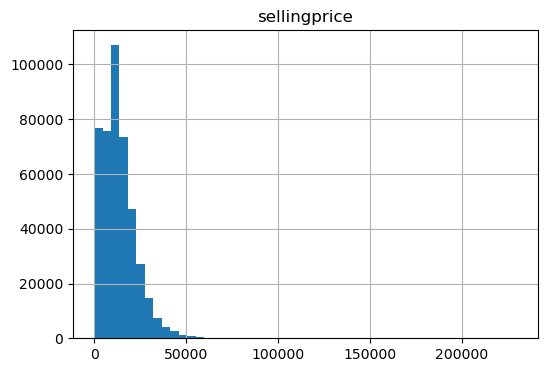

In [20]:
hist_pattern(df_train['sellingprice'], 'sellingprice')

In [21]:
# Определим состав признака sellingprice
df_train['sellingprice'].value_counts().sort_index()

1          2
100       16
125        1
150       18
175       10
          ..
169500     1
171500     1
173000     1
183000     1
230000     1
Name: sellingprice, Length: 1735, dtype: int64

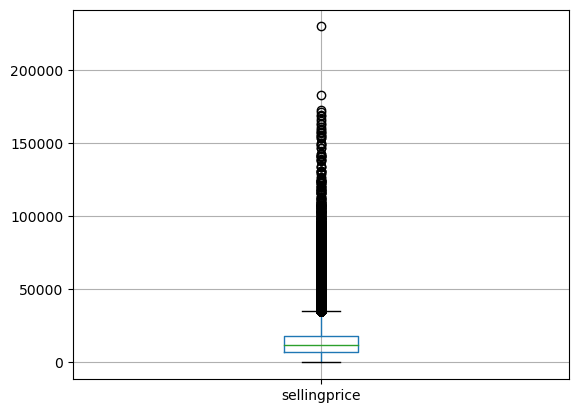

In [22]:
# Изобразим выбросы на графике
df_train.loc[:, ['sellingprice']].boxplot()
plt.show()

In [23]:
# Определим верхний уровень выбросов
price_mean = df_train['sellingprice'].mean()
price_std = np.std(list(df_train['sellingprice']), ddof=1)
sig_max = price_mean + 3 * price_std
print('Верхний уровень выброса - ', sig_max)

Верхний уровень выброса -  42846.64688071322


In [24]:
# Определим нижний уровень выбросов
print('Нижний уровень выброса - ', df_train['sellingprice'].quantile(0.05))

Нижний уровень выброса -  1500.0


In [25]:
price_list = df_train['sellingprice'].value_counts().sort_index()
print('Количество нижних выбросов', price_list[price_list.index < 1500].sum())
print('Количество верхних выбросов', price_list[price_list.index > 42846].sum())

Количество нижних выбросов 21223
Количество верхних выбросов 5446


Судя по графику и значению квантиля 5% – выбросом является цены со значением менее 1 500 (21 223 повторения).

Используя правило трех сигм определена верхняя граница выброса – 42 846 (5 446 повторений)

In [26]:
# Определим состав признака odometer
df_train['odometer'].value_counts().sort_index()

1.0         1059
2.0           11
3.0            6
4.0            8
5.0            8
            ... 
537334.0       1
694978.0       2
959276.0       1
980113.0       1
999999.0      55
Name: odometer, Length: 159364, dtype: int64

In [27]:
odometer_list = df_train['odometer'].value_counts().sort_index()
print('Количество данных верхнего выброса', odometer_list[odometer_list.index > 500000].sum())

Количество данных верхнего выброса 62


In [28]:
# Список категориальных признаков
list_clusters = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

In [29]:
# Число уникальных значений в каждлом категориальном столбце
for i in list_clusters:
    print(i, '-', len(df_train[i].unique()))

make - 93
model - 960
trim - 1923
body - 86
transmission - 3
state - 38
color - 21
interior - 18
seller - 13025


### Общие выводы по качеству имеющихся данных <a id='1.3'></a>

Датасет содержит `15` столбцов и `440 236` строк. Общее число пропусков `97 003`.

Основные показатели датасета имеют отклонения от нормального распределения. 

Данные по годам выпуска автомобилей (`year`) смещены вправо. В основном, на рынке представлены автомобили с `2010` по `2015` гг. Есть ряд данных до `1995` года, которые могут считаться аномалиями. Стоимость таких автомобилей очень низкая и они будут оказывать отрицательное влияние на обучение модели. Из графика также видно очень незначительное количество автомобилей с ручной коробкой передач. Такой перекос данных также окажет негативное влияние на итоговую оценку. При этом, имеет место зависимость между ценой продажи и годом, что наглядно показано на графике.

Параметр состояния автомобиля (`condition`) также коррелирует с ценой продажи, но в отличии от года выпуска имеет более равномерное распределение (низкую степень смещения показывает незначительное отклонение среднего значения от медианы). Это позволит эффективно применить данный параметр для прогнозирования. Необходимо изменить тип данного параметра на действительное число.

Данные о пробеге машины (`odometer`) значительно смещены влево. Среднее значительно превышает медианное значение. При этом разброс значений очень значимый. Параметр содержит аномальные значения, которые нельзя удалять для избегания переобучения модели.

Цена продажи (`sellingprice`), так же существенно смещена влево. Параметр содержит определенное количество аномальных значений. Значение квантиля `5%` показало, что выбросом являются цены со значением менее `1 500` (`21 223` повторения). Используя правило трех сигм, определена верхняя граница выброса – `42 846` (`5 446` повторений). Тем не менее, для избегания переобучения модели, выбросы удалять не будем.

Данные о дате продажи не приведены в тип `data`. Кроме того, есть предположение, что на прогнозирование цены могут влиять параметры месяца, дня недели, времени года.

Показатель `vin` можно использовать для уточнения параметров автомобиля, взяв для это `4-9` цифру `vin`.

В связи с тем, что на контрольном датасете ни каких удалений делать нельзя, то убирать выбросы из обучающего датасета не целесообразно, поскольку это может привести к переобучению модели.

## Подготовка данных <a id='2'></a>

### Предобработка данных <a id='2.1'></a>

**План по предобработке данных**

- Преобразуем дату продажи в формат datetime
- Создать столбцы месяц, день месяца, день недели, времени года, возраст автомобиля
- Преобразовать condition в тип float
- Добавить уникальный класс модели по vin
- Заполнить пропуски: 0 для числовых и no_answ для категориальных
- Привести все категориальные признаки в нижний регистр

In [30]:
# Преобразуем дату продажи в формат datetime
df_train['saledate'] = pd.to_datetime(df_train['saledate'], utc=True)

# создадим столбцы месяц, день месяца, день недели
df_train['month'] = df_train['saledate'].dt.month
df_train['month_day'] = df_train['saledate'].dt.day
df_train['week_day'] = df_train['saledate'].dt.weekday

# создадим стобец времени года
df_train['season'] = df_train['month'].apply(season)

# создадим стобец возраста автомобиля
df_train['age'] = df_train['saledate'].dt.year - df_train['year']

# Преобразуем condition в тип float
df_train['condition'] = df_train['condition'].astype('float')

# Добавим уникальный класс модели по vin
df_train['vin_sh'] = df_train['vin'].apply(lambda x: x[3:9])

In [31]:
# Заполнение пропусков
# Для числовых признаков - 0
# Для категориальных признаков - no_answ
df_train['odometer'] = df_train['odometer'].fillna(0)
df_train['condition'] = df_train['condition'].fillna(0)
df_train = df_train.fillna('no_answ')

In [32]:
# Проверка пропусков
df_train.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
vin_transmis    0
month           0
month_day       0
week_day        0
season          0
age             0
vin_sh          0
dtype: int64

In [33]:
# Обновим список категориальных признаков
list_clusters.append('vin_sh')
list_clusters

['make',
 'model',
 'trim',
 'body',
 'transmission',
 'state',
 'color',
 'interior',
 'seller',
 'vin_sh']

In [34]:
# Все категориальные признаки приведем в нижний регистр
for i in list_clusters:
    df_train[i] = df_train[i].apply(lambda x: x.lower())

In [35]:
df_train.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,seller,sellingprice,saledate,vin_transmis,month,month_day,week_day,season,age,vin_sh
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,...,santander consumer,12500,2015-06-01 19:30:00+00:00,j,6,1,0,3,4,dk3jc4
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,...,ars/avis budget group,14500,2015-02-24 18:00:00+00:00,h,2,24,1,1,1,6p0h75
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,...,nissan-infiniti lt,9100,2015-06-09 19:30:00+00:00,a,6,9,1,3,3,ab6ap4


In [36]:
info_df(df_train)

Размер таблиы: 22 столбцов и 440236 строк
Общее количество пропусков - 0
year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
vin_transmis    0
month           0
month_day       0
week_day        0
season          0
age             0
vin_sh          0
dtype: int64

Количество явных дубликатов: 0
Количество уникальных VIN: 440236

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   year          440236 non-null  int64              
 1   make          440236 non-null  object             
 2   model         440236 non-null  object             
 3   trim          440236 non-null  object             
 4  

,year,condition,odometer,sellingprice,month,month_day,week_day,season,age
count,440236.00,440236.00,440236.00,440236.00,440236.00,440236.00,440236.00,440236.00,440236.00
mean,2010.04,3.35,68333.71,13592.21,3.82,14.65,1.47,1.54,4.86
std,3.98,1.06,53544.84,9751.48,3.24,8.59,1.24,0.78,3.95
min,1982.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,-1.00
25%,2007.00,2.60,28249.00,6900.00,1.00,7.00,1.00,1.00,2.00
50%,2012.00,3.50,52089.00,12100.00,2.00,16.00,1.00,1.00,3.00
75%,2013.00,4.20,99266.00,18200.00,6.00,21.00,2.00,2.00,7.00
max,2015.00,5.00,999999.00,230000.00,12.00,31.00,6.00,3.00,33.00


### Проверка данных на мультиколлинеарность <a id='2.2'></a>

In [37]:
# Проведем корреляционный анализ
df_corr = df_train.drop('vin', axis=1)
df_corr.corr().loc[:, 'sellingprice'].sort_values(ascending=False)

C:\Users\User\AppData\Local\Temp\ipykernel_9008\2653108403.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr.corr().loc[:, 'sellingprice'].sort_values(ascending=False)


sellingprice    1.000000
year            0.586847
condition       0.521459
season          0.072139
week_day       -0.001741
month_day      -0.010603
month          -0.031175
odometer       -0.582726
age            -0.584540
Name: sellingprice, dtype: float64

C:\Users\User\AppData\Local\Temp\ipykernel_9008\3085585491.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_plot = sns.heatmap(df_corr.corr(), cmap="YlGnBu", annot=True, fmt='.1g',


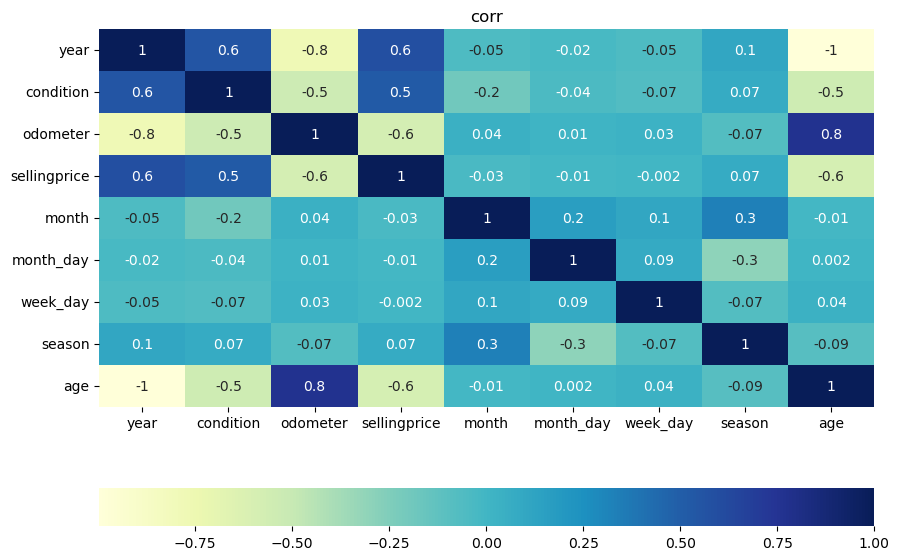

In [38]:
# Построим тепловую карту
plt.figure(figsize=(10, 7))
df_plot = sns.heatmap(df_corr.corr(), cmap="YlGnBu", annot=True, fmt='.1g',
                     cbar_kws= {'orientation': 'horizontal'})
plt.title('corr')
plt.show()

In [39]:
# Удалим столбцы week_day, month_day, month, age, saledate из признаков
df_train.drop(['week_day', 'month_day', 'month', 'age', 'saledate'], axis=1, inplace=True)
df_train.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,vin_transmis,season,vin_sh
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,j,3,dk3jc4
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,h,1,6p0h75
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,a,3,ab6ap4


In [40]:
# Столбец vin сделаем индексом
df_train = df_train.set_index('vin')
df_train.head(3)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,vin_transmis,season,vin_sh
vin,,,,,,,,,,,,,,,,
2fmdk3jc4bba41556,2011,ford,edge,sel,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,j,3,dk3jc4
3fa6p0h75er208976,2014,ford,fusion,se,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,h,1,6p0h75
3n1ab6ap4cl698412,2012,nissan,sentra,2.0 sl,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,a,3,ab6ap4


### Общие выводы по подготовке данных <a id='2.3'></a>

Сформирован сбалансированный набор показателей для эффективного прогнозирования цены продажи автомобиля.

По результату корреляционного анализа, не выявлена зависимость цены продажи ни с одним из показателей даты кроме сезона.

Проверка данных на мультиколлинеарность показала наличие параметров с высоким уровнем пересекающейся корреляции. Снижение уровня мультиколлинеарности было достигнуто удалением следующих параметров: `week_day`, `month_day`, `month`, `age`. Кроме того, отсутствует необходимость в параметре `saledate`.

Для обеспечения однозначной идентификации автомобиля, показатель `vin` вынесен в индекс датасета.

## Обучение моделей <a id='3'></a>

### Пробразование категорий в число <a id='3.1'></a>

In [41]:
# Списки измнения категориальных параметров и добавления числовых
list_in = ['make', 'model', 'body', 'transmission',  'state', 'color', 'interior', 'seller', 'trim', 'vin_sh']
list_out_i = ['make_numi', 'model_numi', 'body_numi', 'transmission_numi',  'state_numi', 'color_numi', 'interior_numi', 'seller_numi', 'trim_numi', 'vin_sh_numi']
list_out_s = ['make_nums', 'model_nums', 'body_nums', 'transmission_nums',  'state_nums', 'color_nums', 'interior_nums', 'seller_nums', 'trim_nums', 'vin_sh_nums']
list_num = ['year', 'condition', 'odometer', 'sellingprice', 'season']

In [42]:
# Преобразуем make, model, body, transmission,  state, color, interior в число
# Метод word_int
df_train_short = pd.DataFrame()

for i in range(len(list_in)):
    df_train_short[list_out_i[i]] = df_train[list_in[i]].apply(word_int)

for i in range(len(list_num)):
    df_train_short[list_num[i]] = df_train[list_num[i]]


In [43]:
df_train_short.head(3)

,make_numi,model_numi,body_numi,transmission_numi,state_numi,color_numi,interior_numi,seller_numi,trim_numi,vin_sh_numi,year,condition,odometer,sellingprice,season
vin,,,,,,,,,,,,,,,
2fmdk3jc4bba41556,1066,1014,703,4793,309,1536,1536,17831,641,1698,2011,4.2,111041.0,12500,3
3fa6p0h75er208976,1066,2316,1555,4793,331,1536,1536,23070,317,1431,2014,3.5,31034.0,14500,1
3n1ab6ap4cl698412,2270,2263,1555,4793,322,1536,1536,16910,1637,1715,2012,2.2,35619.0,9100,3


In [44]:
# Преобразуем make, model, body, transmission,  state, color, interior в число
# Метод word_str
df_train_long = pd.DataFrame()

for i in range(len(list_in)):
    df_train_long[list_out_s[i]] = df_train[list_in[i]].apply(word_str)

for i in range(len(list_num)):
    df_train_long[list_num[i]] = df_train[list_num[i]]


In [45]:
df_train_long.head(3)

,make_nums,model_nums,body_nums,transmission_nums,state_nums,color_nums,interior_nums,seller_nums,trim_nums,vin_sh_nums,year,condition,odometer,sellingprice,season
vin,,,,,,,,,,,,,,,
2fmdk3jc4bba41556,102222342400,101200309404,115234354,97234348444545582812840891,109200,98216291396535,98216291396535,1151943304644856607008081026320108913321430161...,115202324,100214153424495312,2011,4.2,111041.0,12500,3
3fa6p0h75er208976,102222342400,102234345420555660,115202300388550,97234348444545582812840891,109222,98216291396535,98216291396535,9722834518848570873592028898012871200133914141...,115202,54224144416275318,2014,3.5,31034.0,14500,1
3n1ab6ap4cl698412,110210345460485660,115202330464570582,115202300388550,97234348444545582812840891,110212,98216291396535,98216291396535,1102103454604856603158409901020115513201365162...,5092144128575648,97196162388560312,2012,2.2,35619.0,9100,3


### Проверка метода word_str. Объединение значений символов <a id='3.2'></a>

In [46]:
# Разделим таблицу на признаки и целевые результаты
features_long = df_train_long.drop(['sellingprice'], axis=1)
target_long = df_train_long['sellingprice']

display(features_long.head(3))

,make_nums,model_nums,body_nums,transmission_nums,state_nums,color_nums,interior_nums,seller_nums,trim_nums,vin_sh_nums,year,condition,odometer,season
vin,,,,,,,,,,,,,,
2fmdk3jc4bba41556,102222342400,101200309404,115234354,97234348444545582812840891,109200,98216291396535,98216291396535,1151943304644856607008081026320108913321430161...,115202324,100214153424495312,2011,4.2,111041.0,3
3fa6p0h75er208976,102222342400,102234345420555660,115202300388550,97234348444545582812840891,109222,98216291396535,98216291396535,9722834518848570873592028898012871200133914141...,115202,54224144416275318,2014,3.5,31034.0,1
3n1ab6ap4cl698412,110210345460485660,115202330464570582,115202300388550,97234348444545582812840891,110212,98216291396535,98216291396535,1102103454604856603158409901020115513201365162...,5092144128575648,97196162388560312,2012,2.2,35619.0,3


In [47]:
# Разделим данные на обучающую и тестовую выборки

features_train_l, features_test_l, target_train_l, target_test_l = train_test_split(features_long, target_long,
                                                                            test_size=.25,                                                                            
                                                                            random_state=state)
print(f'Обучающая выборка признаков - {features_train_l.shape}')
print(f'Обучающая выборка целевого признака - {target_train_l.shape}')
print(f'Тестовая выборка признаков - {features_test_l.shape}')
print(f'Тестовая выборка целевого признака - {target_test_l.shape}')

Обучающая выборка признаков - (330177, 14)
Обучающая выборка целевого признака - (330177,)
Тестовая выборка признаков - (110059, 14)
Тестовая выборка целевого признака - (110059,)


In [48]:
# Проверим качество метода на лмнейной регрессии
model_regr_long = LinearRegression()
model_regr_long.fit(features_train_l, target_train_l)
answer_regr_long = model_regr_long.predict(features_test_l)
mape_model_regr_long = mean_absolute_percentage_error(target_test_l, answer_regr_long)
print(f'MAPE на регрессии с преобразованием категорий объединением - {mape_model_regr_long:.4f}')

MAPE на регрессии с преобразованием категорий объединением - 1.9559


**Вывод**

Качество прогноза очень низкое, поэтому отвергаем метод преобразования word_str

### Проверка метода word_int. Сумма значений символов <a id='3.3'></a>

In [50]:
# Разделим таблицу на признаки и целевые результаты
features_short = df_train_short.drop(['sellingprice'], axis=1)
target_short = df_train_short['sellingprice']

display(features_short.head(3))

,make_numi,model_numi,body_numi,transmission_numi,state_numi,color_numi,interior_numi,seller_numi,trim_numi,vin_sh_numi,year,condition,odometer,season
vin,,,,,,,,,,,,,,
2fmdk3jc4bba41556,1066,1014,703,4793,309,1536,1536,17831,641,1698,2011,4.2,111041.0,3
3fa6p0h75er208976,1066,2316,1555,4793,331,1536,1536,23070,317,1431,2014,3.5,31034.0,1
3n1ab6ap4cl698412,2270,2263,1555,4793,322,1536,1536,16910,1637,1715,2012,2.2,35619.0,3


In [51]:
# Разделим данные на обучающую и тестовую выборки

features_train_s, features_test_s, target_train_s, target_test_s = train_test_split(features_short, target_short,
                                                                            test_size=.25,                                                                            
                                                                            random_state=state)
print(f'Обучающая выборка признаков - {features_train_s.shape}')
print(f'Обучающая выборка целевого признака - {target_train_s.shape}')
print(f'Тестовая выборка признаков - {features_test_s.shape}')
print(f'Тестовая выборка целевого признака - {target_test_s.shape}')

Обучающая выборка признаков - (330177, 14)
Обучающая выборка целевого признака - (330177,)
Тестовая выборка признаков - (110059, 14)
Тестовая выборка целевого признака - (110059,)


In [52]:
# Проведем стандартизацию данных

scaler = StandardScaler()
scaler.fit(features_train_s)
features_train_skaled = scaler.transform(features_train_s)
features_test_skaled = scaler.transform(features_test_s)

print(f'Обучающая стандартизированная выборка признаков - {features_train_skaled.shape}')
print(f'Тестовая стандартизированная выборка признаков - {features_test_skaled.shape}')

Обучающая стандартизированная выборка признаков - (330177, 14)
Тестовая стандартизированная выборка признаков - (110059, 14)


### Модель линейной регрессии <a id='3.4'></a>

**Модель линейной регрессии будет применена:**
- На исходной выборке
- На сокращенной выборке
- На стандартизированной  выборке

In [53]:
# Обучим модель линейной регрессии
model_regr_short = LinearRegression()
model_regr_short.fit(features_train_s, target_train_s)
answer_regr_short = model_regr_short.predict(features_test_s)
mape_model_regr_short = mean_absolute_percentage_error(target_test_s, answer_regr_short)
print(f'MAPE на регрессии с преобразованием категорий суммой - {mape_model_regr_short:.4f}')

MAPE на регрессии с преобразованием категорий суммой - 0.7038


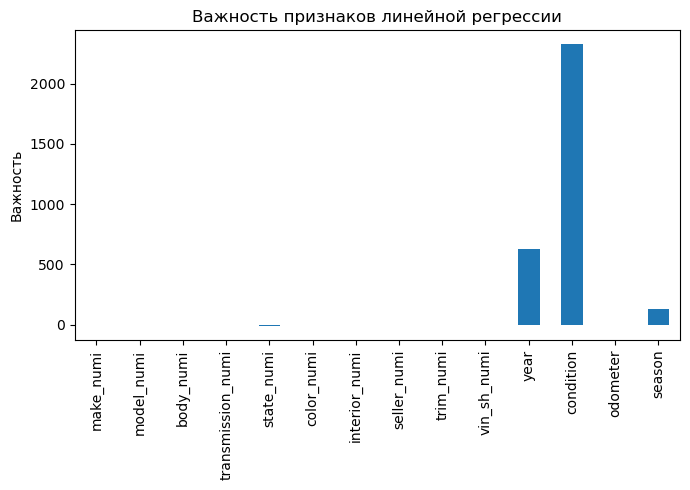

In [54]:
# Построим таблицу признаков линейной регрессии
coefs_reg = pd.DataFrame({
    'params': features_train_s.columns,
    'coef_reg': model_regr_short.coef_
})

# Постриои график признаков
fig, ax = plt.subplots(figsize=(7,5))
coefs_reg.plot.bar(ax=ax)
ax.set_title("Важность признаков линейной регрессии")
ax.set_ylabel('Важность')
ax.set_xticklabels(coefs_reg['params'])
ax.get_legend().remove()
fig.tight_layout()

In [55]:
# Для регрессии важны только три признака. 
# Изменим feature
features_train_s_reg = features_train_s[['year', 'condition', 'season']]
features_test_s_reg = features_test_s[['year', 'condition', 'season']]

print(f'Обучающая выборка признаков для регрессии - {features_train_s_reg.shape}')
print(f'Тестовая выборка признаков для регрессии - {features_test_s_reg.shape}')


Обучающая выборка признаков для регрессии - (330177, 3)
Тестовая выборка признаков для регрессии - (110059, 3)


In [56]:
# Обучим модель линейной регрессии на коротком датасете
model_regr_short_short = LinearRegression()
model_regr_short_short.fit(features_train_s_reg, target_train_s)
answer_regr_short_short = model_regr_short_short.predict(features_test_s_reg)
mape_model_regr_short_short = mean_absolute_percentage_error(target_test_s, answer_regr_short_short)
print(f'MAPE на регрессии на коротком датасете - {mape_model_regr_short_short:.4f}')

MAPE на регрессии на коротком датасете - 0.7302


In [57]:
# Обучим модель линейной регрессии на стандартизирванной выборке
model_regr_skaled = LinearRegression()
model_regr_skaled.fit(features_train_skaled, target_train_s)
answer_regr_skaled = model_regr_skaled.predict(features_test_skaled)
mape_model_regr_skaled = mean_absolute_percentage_error(target_test_s, answer_regr_skaled)
print(f'MAPE на регрессии на стандартизирванной выборке - {mape_model_regr_skaled:.4f}')

MAPE на регрессии на стандартизирванной выборке - 0.7038


### Модель Решающего дерева <a id='3.5'></a>

**Модель Решающего дерева будет применена:**
- На исходной выборке
- На сокращенной выборке
- На стандартизированной  выборке

In [58]:
# Обучим модель Решающего дерева
model_tree_short = DecisionTreeRegressor(max_depth=10, random_state=state)
model_tree_short.fit(features_train_s, target_train_s)
answer_model_tree_short = model_tree_short.predict(features_test_s)
mape_model_tree_short = mean_absolute_percentage_error(target_test_s, answer_model_tree_short)
print(f'MAPE на дереве с преобразованием категорий суммой - {mape_model_tree_short:.4f}')

MAPE на дереве с преобразованием категорий суммой - 0.3538


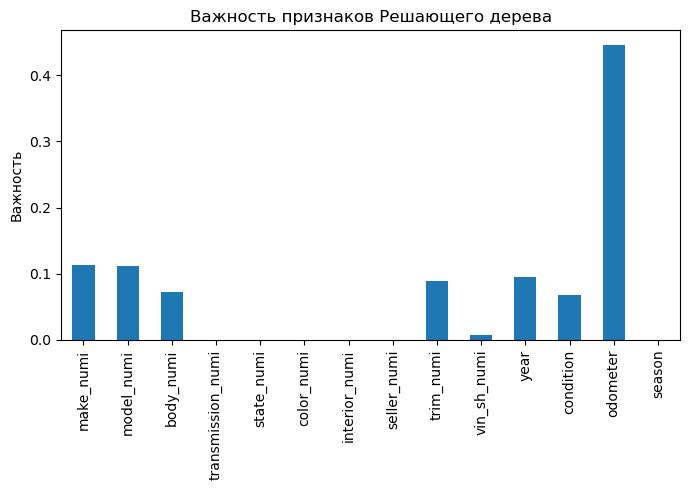

In [59]:
# Построим таблицу признаков Решающего дерева
coefs_tree = pd.DataFrame({
    'params': features_train_s.columns,
    'coef_tree': model_tree_short.feature_importances_
})

# Постриои график признаков
fig, ax = plt.subplots(figsize=(7,5))
coefs_tree.plot.bar(ax=ax)
ax.set_title("Важность признаков Решающего дерева")
ax.set_ylabel('Важность')
ax.set_xticklabels(coefs_tree['params'])
ax.get_legend().remove()
fig.tight_layout()

In [60]:
# Для Решающего дерева важны семь признаков.
# Изменим feature

features_train_s_tr = features_train_s[['make_numi', 'model_numi', 'body_numi', 'trim_numi', 'year', 'condition', 'odometer']]
features_test_s_tr = features_test_s[['make_numi', 'model_numi', 'body_numi', 'trim_numi', 'year', 'condition', 'odometer']]

print(f'Обучающая выборка признаков для Решающего дерева - {features_train_s_tr.shape}')
print(f'Тестовая выборка признаков для Решающего дерева - {features_test_s_tr.shape}')


Обучающая выборка признаков для Решающего дерева - (330177, 7)
Тестовая выборка признаков для Решающего дерева - (110059, 7)


In [61]:
# Обучим модель Решающего дерева на короткот датасете
model_tree_short_short = DecisionTreeRegressor(max_depth=10, random_state=state)
model_tree_short_short.fit(features_train_s_tr, target_train_s)
answer_model_tree_short_short = model_tree_short_short.predict(features_test_s_tr)
mape_model_tree_short_short = mean_absolute_percentage_error(target_test_s, answer_model_tree_short_short)
print(f'MAPE на дереве на коротком датасете - {mape_model_tree_short_short:.4f}')

MAPE на дереве на коротком датасете - 0.3528


In [62]:
# Обучим модель Решающего дерева на стандартизирванной выборке
model_tree_skaled = DecisionTreeRegressor(max_depth=10, random_state=state)
model_tree_skaled.fit(features_train_skaled, target_train_s)
answer_model_tree_skaled = model_tree_skaled.predict(features_test_skaled)
mape_model_tree_skaled = mean_absolute_percentage_error(target_test_s, answer_model_tree_skaled)
print(f'MAPE на дереве на стандартизирванной выборке - {mape_model_tree_skaled:.4f}')

MAPE на дереве на стандартизирванной выборке - 0.3537


### Методы улучшения качества моделей <a id='3.6'></a>

**Улучшение качества моделей:**
- с использованием кросс-валидации
- с подбором параметра Решающего дерева методом GridSearchCV
- с подбором числа деревьев Случайного леса 
- с использованием Фреймворка LightGBM
- с использованием Фреймворка CatBoost

In [63]:
# Обучим модель методом линейной регрессии с использованием кросс-валидация (3 частей)
line_regr_cross_valid_list = []
all_line = len(target_train_s)
sample_size = int(all_line//3.1)

for i in range(0, all_line, sample_size):
    if i+sample_size >= all_line:
        break
    else:
        valid_indexes = list(range(i, i+sample_size)) 
        train_indexes = list(range(0, i)) + list(range(i+sample_size, all_line))

        # Создадим выборки методом кросс-валидация и обучим модель
        features_train_short = features_train_s.loc[features_train_s.index[train_indexes]]
        target_train_short = target_train_s.loc[target_train_s.index[train_indexes]]
        features_valid_short = features_train_s.loc[features_train_s.index[valid_indexes]]
        target_valid_short = target_train_s.loc[target_train_s.index[valid_indexes]]
    
        model_line_regr_cross_valid = LinearRegression()
        model_line_regr_cross_valid.fit(features_train_short, target_train_short)
        predict_test = model_line_regr_cross_valid.predict(features_valid_short)

        # Проверим качество модели
        mape_test_short = mean_absolute_percentage_error(target_valid_short, predict_test)
        line_regr_cross_valid_list.append(mape_test_short)
    
# Рассчитаем среднее качество модели
fin_line_regr_cross_valid_list = sum(line_regr_cross_valid_list) / len(line_regr_cross_valid_list)
print(f'На модели логистической регрессии средний уровень MAPE = {fin_line_regr_cross_valid_list:.4f}')

answer_line_regr_cross_valid = model_line_regr_cross_valid.predict(features_test_s)
mape_model_line_regr_cross_valid = mean_absolute_percentage_error(target_test_s, answer_line_regr_cross_valid)

print(f"С использованем кросс-валидации точность модели по MAPE: {mape_model_line_regr_cross_valid:.4f}")


На модели логистической регрессии средний уровень MAPE = 0.7746
С использованем кросс-валидации точность модели по MAPE: 0.7039


In [64]:
# Подберем лучшие параметры Решающего дерева методом GridSearchCV
clf = DecisionTreeRegressor(random_state=state)
parametrs = {'max_depth': range(10, 26, 5)}

model_tree_regr = GridSearchCV(clf, parametrs, cv=3)
model_tree_regr.fit(features_train_s, target_train_s)
best_depth_tree_regr = model_tree_regr.best_params_.get('max_depth')
print(f'Лучший параметр глубины - {best_depth_tree_regr}')

# Обучим и проверим модель с подобранными параметрами
model_tree = DecisionTreeRegressor(max_depth=best_depth_tree_regr, random_state=state)
model_tree.fit(features_train_s, target_train_s)

answer_model_tree = model_tree.predict(features_test_s)
mape_model_tree = mean_absolute_percentage_error(target_test_s, answer_model_tree)

print(f"Точность модели Решающего дерева методом GridSearchCV по MAPE: {mape_model_tree:.4f}")


Лучший параметр глубины - 20
Точность модели Решающего дерева методом GridSearchCV по MAPE: 0.2315


In [65]:
# Улучшим модель Решающего дерева меняя число деревьев
best_result_forest = 1000
best_est_forest = 0
best_model_forest = 0
best_rmse_model_forest = 0

for est in range(10, 21, 10):
    model_forest = RandomForestRegressor(random_state=state,
                                   n_estimators=est, 
                                   max_depth=best_depth_tree_regr)
    model_forest.fit(features_train_s, target_train_s)
    predict_model_forest = model_forest.predict(features_test_s)
    test_model_forest = mean_absolute_percentage_error(target_test_s, predict_model_forest)
    
    if best_result_forest > test_model_forest:
        best_result_forest = test_model_forest
        best_est_forest = est
        best_model_forest = model_forest
        best_mape_model_forest = test_model_forest
print(f'Лучший параметр числа деревьев - {best_est_forest}')

answer_model_forest = best_model_forest.predict(features_test_s)
mape_model_forest = mean_absolute_percentage_error(target_test_s, answer_model_forest)

print(f"Точность модели Случайного леса по MAPE: {mape_model_forest:.4f}")


Лучший параметр числа деревьев - 20
Точность модели Случайного леса по MAPE: 0.1963


In [66]:
# Создадим модель с использованием Фреймворка LightGBM
lgb_model = lgb.LGBMModel(objective="regression", n_estimators=3000)
lgb_model.fit(features_train_s, target_train_s, eval_set=[(features_test_s, target_test_s),], eval_metric="mape")

answerr_lgb_model = lgb_model.predict(features_test_s)
mape_lgb_model = mean_absolute_percentage_error(target_test_s, answerr_lgb_model)

print(f"Точность модели LightGBM по MAPE: {mape_lgb_model:.4f}")


[1]	valid_0's mape: 1.6835	valid_0's l2: 8.50249e+07
[1000]	valid_0's mape: 0.179172	valid_0's l2: 4.9178e+06
[2000]	valid_0's mape: 0.167707	valid_0's l2: 4.33842e+06
[3000]	valid_0's mape: 0.162176	valid_0's l2: 4.15284e+06
Точность модели LightGBM по MAPE: 0.1622


In [67]:
# Создадим модель с использованием Фреймворка LightGBM на стандартизированных данных
lgb_model_skaled = lgb.LGBMModel(objective="regression", n_estimators=10000)
lgb_model_skaled.fit(features_train_skaled, target_train_s, eval_set=[(features_test_skaled, target_test_s),], eval_metric="mape")

answerr_lgb_model_skaled = lgb_model_skaled.predict(features_test_skaled)
mape_lgb_model_skaled = mean_absolute_percentage_error(target_test_s, answerr_lgb_model_skaled)

print(f"Точность модели LightGBM по MAPE: {mape_lgb_model_skaled:.4f}")

[1]	valid_0's mape: 1.6835	valid_0's l2: 8.50145e+07
[1000]	valid_0's mape: 0.178267	valid_0's l2: 4.74169e+06
[2000]	valid_0's mape: 0.166757	valid_0's l2: 4.27306e+06
[3000]	valid_0's mape: 0.16158	valid_0's l2: 4.06693e+06
[4000]	valid_0's mape: 0.15841	valid_0's l2: 3.9545e+06
[5000]	valid_0's mape: 0.156489	valid_0's l2: 3.90142e+06
[6000]	valid_0's mape: 0.155285	valid_0's l2: 3.87238e+06
[7000]	valid_0's mape: 0.154436	valid_0's l2: 3.84695e+06
[8000]	valid_0's mape: 0.1539	valid_0's l2: 3.8311e+06
[9000]	valid_0's mape: 0.153232	valid_0's l2: 3.81739e+06
[10000]	valid_0's mape: 0.153048	valid_0's l2: 3.80839e+06
Точность модели LightGBM по MAPE: 0.1530


In [68]:
# Создадим модель с использованием Фреймворка CatBoost

# инициализируем метод Pool
train_pool = Pool(features_train_s, target_train_s)
test_pool = Pool(features_test_s) 

# зададим параметры модели
cb_model = CatBoostRegressor(iterations=10, 
                             depth=10, 
                             learning_rate=1,
                             loss_function='MAPE')
# обучим модель
cb_model.fit(train_pool)

# провеоим точность модели
cb_preds = cb_model.predict(test_pool)
print(cb_preds)
print()
mape_cb_model = mean_absolute_percentage_error(target_test_s, cb_preds)
print(f'MAPE на CatBoost - {mape_cb_model:.4f}')

0:	learn: 0.7634195	total: 536ms	remaining: 4.82s
1:	learn: 0.7609725	total: 1.03s	remaining: 4.13s
2:	learn: 0.7592943	total: 1.41s	remaining: 3.29s
3:	learn: 0.7563421	total: 1.78s	remaining: 2.67s
4:	learn: 0.7563016	total: 2.02s	remaining: 2.02s
5:	learn: 0.7563016	total: 2.17s	remaining: 1.45s
6:	learn: 0.7558006	total: 2.52s	remaining: 1.08s
7:	learn: 0.7555410	total: 2.85s	remaining: 714ms
8:	learn: 0.7554452	total: 3.17s	remaining: 352ms
9:	learn: 0.7546099	total: 3.49s	remaining: 0us
[2200. 2200. 2200. ... 2200. 2200. 2200.]

MAPE на CatBoost - 0.7491


### Общие выводы <a id='3.7'></a>

Для построения прогноза было использовано два метода подготовки категориальных данных и три метода их обработки.

Первый метод подготовки (`word_str`) при прогнозе методом линейной регрессии показал низкую точность прогноза, в результате чего был отвергнут. Все дальнейшие прогнозы выстраивались на данных, подготовленных методом `word_int`.

В рамках обработки данных, была применена стандартизация и сокращение числа признаков. `OneHotEncoder` не применялся в связи с чрезмерным разряжением датасета.

Далее было произведено улучшение качества моделей:
- с использованием `кросс-валидации`
- с подбором параметра Решающего дерева методом `GridSearchCV`
- с подбором числа деревьев `Случайного леса` 
- с использованием Фреймворка `LightGBM`
- с использованием Фреймворка `CatBoost`

`Кросс-валидация` не обеспечила роста качества прогноза на методе линейной регрессии. Метод `GridSearchCV` позволил существенно повысить качество прогноза на `Решающем дереве`. Применив лучшие параметры модели `Решающего дерева` построена модель `Случайного леса`, для которой было подобрано наиболее эффективное число деревьев.

Для модели с использованием Фреймворка `ightGBM` были применены как стандартизированный, так о не стандартизированный датасеты, подобрано эффективное количество итераций. Также был проверен прогноз на моделе с использованием Фреймворка `CatBoost`.

Наилучший результата показала модель с использованием Фреймворка `ightGBM` на стандартизированном датасете с числом итерации `10 000`со значение `MAPE` **15.30**. На контрольном датасете эта модель показала жначение `MAPE` **15.08**

## Подготовка контрольного датасета <a id='4'></a>

**Порядок подготовки датасета:**

- Преобразовать дату продажи в формат datetime
- Добавить столбец с временем года
- Преобразовать параметр condition в тип число
- Добавить уникальный класс модели по vin 
- Заполнить пропуски
- Категории привести в нижний регистр
- Параметр vin преобразовать в индекс
- Стандартизировать данные
- Сформировать прогноз с применением выбранной модели
- Создать и записать датасет ответа

In [69]:
df_test.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)


In [70]:
# Преобразуем дату продажи в формат datetime
df_test['saledate'] = pd.to_datetime(df_test['saledate'], utc=True)

# создадим столбцы месяц, время года
df_test['month'] = df_test['saledate'].dt.month
df_test['season'] = df_test['month'].apply(season)

# Преобразуем condition в тип float
df_test['condition'] = df_test['condition'].astype('float')

# Добавим уникальный класс модели по vin
df_test['vin_sh'] = df_test['vin'].apply(lambda x: x[3:9])

In [71]:
# Удалим столбцы month, saledate из признаков
df_test.drop(['month', 'saledate'], axis=1, inplace=True)

In [72]:
# Заполнение пропусков
# Для числовых признаков - 0
# Для категориальных признаков - no_answ
df_test['odometer'] = df_test['odometer'].fillna(0)
df_test['condition'] = df_test['condition'].fillna(0)
df_test = df_test.fillna('no_answ')

In [73]:
# Все категориальные признаки приведем в нижний регистр
for i in list_clusters:
    df_test[i] = df_test[i].apply(lambda x: x.lower())

In [74]:
# Столбец vin сделаем индексом
df_test = df_test.set_index('vin')

In [75]:
df_test.head(3)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,season,vin_sh
vin,,,,,,,,,,,,,,
1g6dp567450124779,2005,cadillac,cts,base,sedan,automatic,ca,2.7,116970.0,silver,black,lexus of stevens creek,1,dp5674
1gtw7fca7e1902207,2014,gmc,savana cargo,2500,van,no_answ,pa,4.4,6286.0,white,gray,u-haul,1,w7fca7
jn8az1mw6dw303497,2013,nissan,murano,s,suv,automatic,oh,4.6,11831.0,gray,black,nissan-infiniti lt,1,az1mw6


In [76]:
# Преобразуем make, model, body, transmission,  state, color, interior в число
# Метод word_int

list_num_s = ['year', 'condition', 'odometer', 'season']

df_test_short = pd.DataFrame()

for i in range(len(list_in)):
    df_test_short[list_out_i[i]] = df_test[list_in[i]].apply(word_int)

for i in range(len(list_num_s)):
    df_test_short[list_num_s[i]] = df_test[list_num_s[i]]


In [77]:
# Стандартизируем данные
features_valid_skaled = scaler.transform(df_test_short)

In [78]:
df_test_short.head(3)

,make_numi,model_numi,body_numi,transmission_numi,state_numi,color_numi,interior_numi,seller_numi,trim_numi,vin_sh_numi,year,condition,odometer,season
vin,,,,,,,,,,,,,,
1g6dp567450124779,3672,676,1555,4793,293,2310,1536,24849,1041,1286,2005,2.7,116970.0,1
1gtw7fca7e1902207,618,7677,642,3078,306,1611,1106,2140,492,1746,2014,4.4,6286.0,1
jn8az1mw6dw303497,2270,2289,703,4793,319,1106,1536,16910,115,1843,2013,4.6,11831.0,1


In [79]:
# Формирование столбца прогноза
df_test_short['predict_price'] = lgb_model_skaled.predict(features_valid_skaled)

In [80]:
df_test_short.reset_index(inplace=True)
df_answ = df_test_short[['vin', 'predict_price']]
df_answ = df_answ.rename(columns={'predict_price':'sellingprice'})

In [81]:
# Создадим датасет ответа
df_answ.head(3)

,vin,sellingprice
0,1g6dp567450124779,4983.189625
1,1gtw7fca7e1902207,22480.470471
2,jn8az1mw6dw303497,18615.843011


In [82]:
# Сравним созданный ответ с требуемым
df_sample.head()

,vin,sellingprice
0,1g6dp567450124779,13592.209588
1,1gtw7fca7e1902207,13592.209588
2,jn8az1mw6dw303497,13592.209588
3,2g1wf5e34d1160703,13592.209588
4,1n6aa0ec3dn301209,13592.209588


In [83]:
# Запись ответов в csv
df_answ.to_csv(path + 'df_answ.csv', index=False)

**Общий вывод**

В результате проведенной работы сформирована модель машинного обучения, которая позволяет определять стоимость подержанного автомобиля. Модель на контрольном детесете показала точность по метрики `MAPE` на уровне **15.08**.